## Exercise 12: Housing Data <br> Michael Hotaling <br> 2020-10-16

Work individually on this assignment. You are encouraged to collaborate on ideas and strategies pertinent to this assignment. Data for this assignment is focused on real estate transactions recorded from 1964 to 2016 and can be found in `Week 6 Housing.xlsx.` Using your skills in statistical correlation, multiple regression and R programming, you are interested in the following variables: Sale Price and several other possible predictors.

Using your ‘clean’ data set from the previous week complete the following:


**1. Explain why you chose to remove data points from your ‘clean’ dataset.**

There are a couple attributes which will be useless for this exercise. Those attributes are
- prop_type
- addr-full
- sitetype
- ctyname
- postalctyn

We can keep the other attributes for now. 

In [73]:
options(warn=-1)
library(psych)
library(corrplot)
library(ggplot2)
library(readxl)
library(tidyr)
library(ggmap)
library(leaps)
library(QuantPsyc)
library(dplyr)
library(readr)
#options(repr.plot.width=4, repr.plot.height=3)

housing <- read_xlsx("week-6-housing.xlsx", sheet = "Sheet2")

housing <- rename(housing,sale_price = "Sale Price", sale_date = "Sale Date")
housing$ctyname <- as.factor(housing$ctyname)
housing$postalctyn <- as.factor(housing$ctyname)
housing$prop_type <- as.factor(housing$prop_type)
housing$current_zoning <- as.factor(housing$current_zoning)
housing$sitetype <- as.factor(housing$sitetype)
housing$sale_warning <- as.factor(housing$sitetype)
housing <- select(housing, -prop_type, -addr_full, -sitetype, -ctyname, -postalctyn)
housing$price_per_sqft_living <- housing$sale_price / housing$square_feet_total_living
housing$price_per_sqft_lot <- housing$sale_price / housing$sq_ft_lot


EDA to explore the data before cleaning

In [74]:
key <- read_file("my_google_key.txt")

In [75]:
register_google(key)

Source : https://maps.googleapis.com/maps/api/staticmap?center=47.683576,-122.06&zoom=12&size=640x640&scale=2&maptype=terrain&language=en-EN&key=xxx=
Source : https://maps.googleapis.com/maps/api/staticmap?center=47.719159,-122.021844&zoom=17&size=640x640&scale=2&maptype=hybrid&language=en-EN&key=xxx=


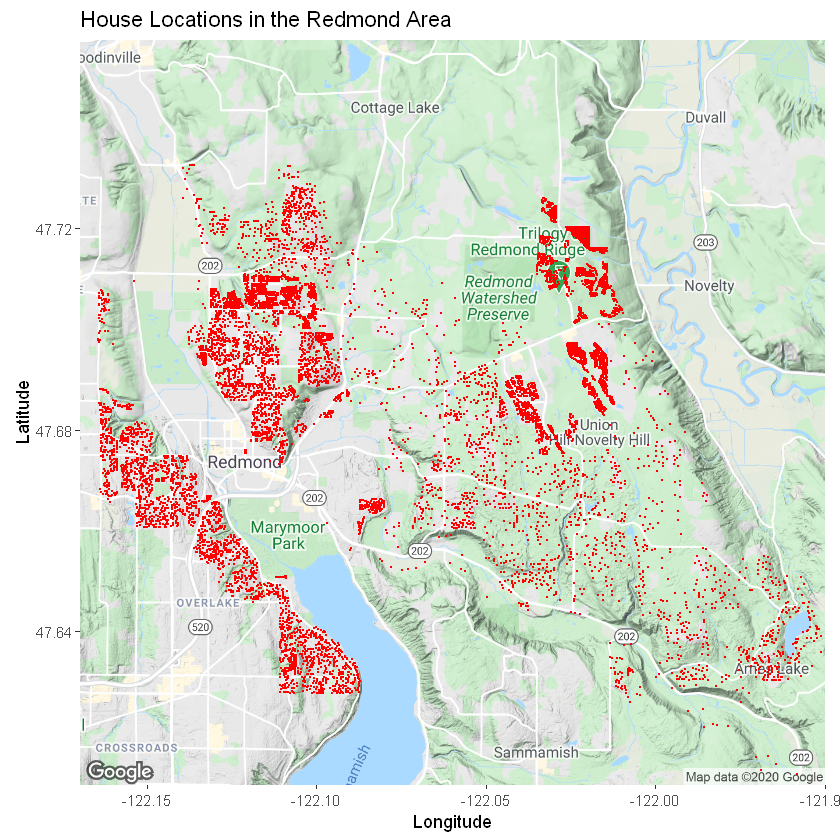

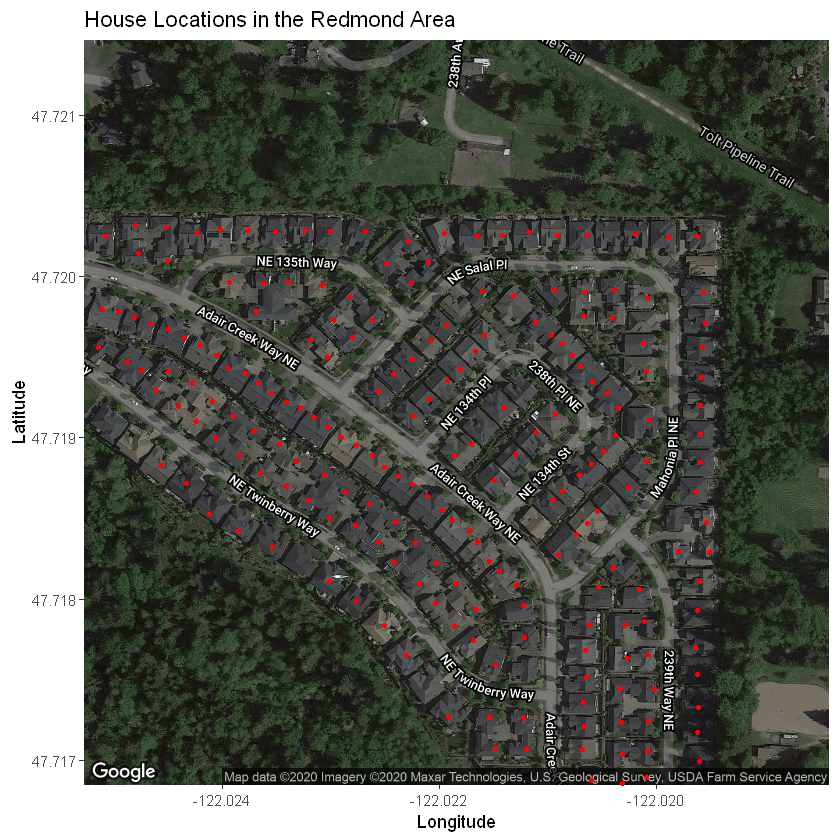

In [76]:
al1 = get_map(location = c(lon = -122.06, lat = mean(df$lat)), 
              zoom = 12, 
              maptype ="terrain")
al1MAP = ggmap(al1)

al1MAP + 
geom_point(data = housing, 
           mapping = aes(x = lon, y = lat), 
           inherit.aes = FALSE,
           size = 0.1,
           color = "red",
           alpha = 1) + 
xlab("Longitude") +
ylab("Latitude") +
ggtitle("House Locations in the Redmond Area") 

al2 = get_map(location = c(lon = -122.021844, lat = 47.719159), 
              zoom = 17, 
              maptype ="hybrid")
al2MAP = ggmap(al2)

al2MAP + 
geom_point(data = subset(housing, sale_price < 1000000), 
           mapping = aes(x = lon, y = lat), 
           inherit.aes = FALSE,
           size = 1,
           color = "red") + 
xlab("Longitude") +
ylab("Latitude") +
ggtitle("House Locations in the Redmond Area")


**2. Create two variables; one that will contain the variables Sale Price and Square Foot of Lot (same variables used from previous assignment on simple regression) and one that will contain Sale Price and several additional predictors of your choice. Explain the basis for your additional predictor selections.**

### The Basic Model: Square Foot of Lot

In [77]:
basic_model <- lm(sale_price ~ sq_ft_lot - 1, data = housing)
summary(basic_model)


Call:
lm(formula = sale_price ~ sq_ft_lot - 1, data = housing)

Residuals:
     Min       1Q   Median       3Q      Max 
-7605058   392610   525767   677587  4360720 

Coefficients:
          Estimate Std. Error t value Pr(>|t|)    
sq_ft_lot   4.6705     0.1039   44.96   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 720200 on 12864 degrees of freedom
Multiple R-squared:  0.1358,	Adjusted R-squared:  0.1357 
F-statistic:  2021 on 1 and 12864 DF,  p-value: < 2.2e-16


### Multiple Regression Model
I'll be using the leaps packages, which allows us to pick the best possible fitting model using an  efficient branch-and-bound algorithm

In [78]:
x = model.matrix(sale_price ~ . -1 -
                 sale_warning - # Excluding due to factor
                 current_zoning -  # Excluding due to factor
                 price_per_sqft_living - # Engineered
                 price_per_sqft_lot - # Engineered
                 zip5 - # May cause overfitting
                 lat - # May cause overfitting
                 lon, # May cause overfitting 
                 data = housing)

y= housing$sale_price

bestmods = leaps(x,y, nbest = 1)

colnames(bestmods$which) <- colnames(x)

In [79]:
bestmods$which

sale_date sale_reason sale_instrument building_grade
1  FALSE     FALSE       FALSE           FALSE         
2  FALSE     FALSE       FALSE           FALSE         
3  FALSE      TRUE       FALSE           FALSE         
4  FALSE      TRUE       FALSE            TRUE         
5  FALSE      TRUE       FALSE            TRUE         
6   TRUE      TRUE       FALSE            TRUE         
7   TRUE      TRUE       FALSE            TRUE         
8   TRUE      TRUE       FALSE            TRUE         
9   TRUE      TRUE       FALSE            TRUE         
10  TRUE      TRUE       FALSE            TRUE         
11  TRUE      TRUE        TRUE            TRUE         
12  TRUE      TRUE        TRUE            TRUE         
13  TRUE      TRUE        TRUE            TRUE         
   square_feet_total_living bedrooms bath_full_count bath_half_count
1  TRUE                     FALSE    FALSE           FALSE          
2  TRUE                     FALSE    FALSE           FALSE          
3  TRUE                     FALSE    FALSE           FALSE          
4  TRUE                     FALSE    FALSE           FALSE          
5  TRUE                     FALSE    FALSE           FALSE          
6  TRUE                     FALSE    FALSE           FALSE          
7  TRUE                     FALSE    FALSE           FALSE          
8  TRUE                     FALSE    FALSE           FALSE          
9  TRUE                     FALSE    FALSE           FALSE          
10 TRUE                      TRUE    FALSE           FALSE          
11 TRUE                      TRUE    FALSE           FALSE          
12 TRUE                      TRUE     TRUE           FALSE          
13 TRUE                      TRUE     TRUE            TRUE          
   bath_3qtr_count year_built year_renovated sq_ft_lot present_use
1  FALSE           FALSE      FALSE          FALSE     FALSE      
2  FALSE            TRUE      FALSE          FALSE     FALSE      
3  FALSE            TRUE      FALSE          FALSE     FALSE      
4  FALSE            TRUE      FALSE          FALSE     FALSE      
5  FALSE            TRUE      FALSE          FALSE      TRUE      
6  FALSE            TRUE      FALSE          FALSE      TRUE      
7  FALSE            TRUE      FALSE           TRUE      TRUE      
8  FALSE            TRUE       TRUE           TRUE      TRUE      
9   TRUE            TRUE       TRUE           TRUE      TRUE      
10  TRUE            TRUE       TRUE           TRUE      TRUE      
11  TRUE            TRUE       TRUE           TRUE      TRUE      
12  TRUE            TRUE       TRUE           TRUE      TRUE      
13  TRUE            TRUE       TRUE           TRUE      TRUE

In [80]:
bestmods$Cp

[1] 514.822551 317.986780 222.225639 172.650704 126.086701  82.409496
 [7]  48.113372  16.011084   7.677517   8.033835  10.003523  12.000230
[13]  14.000000

In [81]:
my_attributes <-  as.vector(colnames(x))[bestmods$which[match(min(bestmods$Cp), bestmods$Cp),]]
print(my_attributes)

[1] "sale_date"                "sale_reason"             
[3] "building_grade"           "square_feet_total_living"
[5] "bath_3qtr_count"          "year_built"              
[7] "year_renovated"           "sq_ft_lot"               
[9] "present_use"             


In [114]:
multi_model <- lm(sale_price ~ 
                    sale_date + 
                    sale_reason + 
                    building_grade + 
                    square_feet_total_living + 
                    bath_3qtr_count + 
                    year_built + 
                    year_renovated + 
                    sq_ft_lot + 
                    present_use - 1, 
                  data = housing)

summary(multi_model)


Call:
lm(formula = sale_price ~ sale_date + sale_reason + building_grade + 
    square_feet_total_living + bath_3qtr_count + year_built + 
    year_renovated + sq_ft_lot + present_use - 1, data = housing)

Residuals:
     Min       1Q   Median       3Q      Max 
-1944743  -117293   -42469    37067  3722549 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
sale_date                 1.664e-04  3.019e-05   5.512 3.61e-08 ***
sale_reason              -1.308e+04  1.177e+03 -11.116  < 2e-16 ***
building_grade            3.826e+04  4.402e+03   8.690  < 2e-16 ***
square_feet_total_living  1.535e+02  4.949e+00  31.007  < 2e-16 ***
bath_3qtr_count          -3.193e+04  4.962e+03  -6.435 1.28e-10 ***
year_built               -1.138e+02  2.508e+01  -4.537 5.75e-06 ***
year_renovated            3.299e+01  1.385e+01   2.382  0.01724 *  
sq_ft_lot                 1.630e-01  5.699e-02   2.861  0.00423 ** 
present_use              -5.835e+02  1.041e+02  -5.605 2.12e-08

**c. Execute a summary() function on two variables defined in the previous step to compare the model results. What are the R2 and Adjusted R2 statistics? Explain what these results tell you about the overall model. Did the inclusion of the additional predictors help explain any large variations found in Sale Price?**

The R-squared of the Basic Model is 

In [83]:
summary(basic_model)$r.squared

[1] 0.1357783

and the adjusted R-squared is

In [84]:
summary(basic_model)$adj.r.squared

[1] 0.1357111

The R-squared of the Multiple Regression Model is

In [85]:
summary(multi_model)$r.squared

[1] 0.7892429


and the adjusted R-squared is

In [86]:
summary(multi_model)$adj.r.squared

[1] 0.7890953

We were able to add more useful variables to our model, which increased our R-squared and Adjusted R-squared values. This means that our multiple attributes model is much better at predicting prices than our basic model.

**d. Considering the parameters of the multiple regression model you have created. What are the standardized betas for each parameter and what do the values indicate?**

In [87]:
library(knitr)

kable(lm.beta(multi_model))



|                         |             x|
|:------------------------|-------------:|
|sale_date                | -3.350976e+06|
|sale_reason              |  2.530822e-01|
|building_grade           |  4.146000e-04|
|square_feet_total_living | -7.814748e+01|
|bath_3qtr_count          | -1.829000e-04|
|year_built               |  1.405100e-03|
|year_renovated           |  9.170000e-05|
|sq_ft_lot                | -8.214564e+01|
|present_use              | -9.775447e-01|

Standardized Beta Coefficients compare the strength of each individual attribute compared to our predictive attribute. The larger the beta, the stronger the effect. For our model, sale_date, sq_ft_lot, and square_feet_total_living have the highest beta, meaning thye have the largest impact on our model. 

**e. Calculate the confidence intervals for the parameters in your model and explain what the results indicate.**

In [88]:
confint(multi_model, level = 0.90)

5 %           95 %         
sale_date                 1.167538e-04  2.160819e-04
sale_reason              -1.502057e+04 -1.114795e+04
building_grade            3.101369e+04  4.549758e+04
square_feet_total_living  1.453102e+02  1.615918e+02
bath_3qtr_count          -4.008822e+04 -2.376469e+04
year_built               -1.550451e+02 -7.253620e+01
year_renovated            1.020696e+01  5.578266e+01
sq_ft_lot                 6.928983e-02  2.567806e-01
present_use              -7.546883e+02 -4.122263e+02

Using these confidence intervals, we can calculate how many data points may fall within a certain range when attempting to use the linear model. In the above confidence intervals, we can expect 90% of our data to fall within those ranges. 

**f. Assess the improvement of the new model compared to your original model (simple regression model) by testing whether this change is significant by performing an analysis of variance.**

In [89]:
library(stats)
anova(basic_model)
aov(basic_model)

Df    Sum Sq       Mean Sq      F value Pr(>F)
sq_ft_lot     1 1.048222e+15 1.048222e+15 2021.07  0    
Residuals 12864 6.671880e+15 5.186474e+11      NA NA

Call:
   aov(formula = basic_model)

Terms:
                   sq_ft_lot    Residuals
Sum of Squares  1.048222e+15 6.671880e+15
Deg. of Freedom            1        12864

Residual standard error: 720171.8
Estimated effects are balanced

In [90]:
anova(multi_model)
aov(multi_model)

Df    Sum Sq       Mean Sq      F value     
sale_date                    1 5.613480e+15 5.613480e+15 44353.988756
sale_reason                  1 2.728005e+13 2.728005e+13   215.548797
building_grade               1 2.832049e+14 2.832049e+14  2237.696629
square_feet_total_living     1 1.554951e+14 1.554951e+14  1228.619044
bath_3qtr_count              1 5.323709e+12 5.323709e+12    42.064411
year_built                   1 2.577284e+12 2.577284e+12    20.363982
year_renovated               1 8.738996e+11 8.738996e+11     6.904974
sq_ft_lot                    1 8.248625e+11 8.248625e+11     6.517515
present_use                  1 3.976216e+12 3.976216e+12    31.417413
Residuals                12856 1.627067e+15 1.265609e+11           NA
                         Pr(>F)       
sale_date                 0.000000e+00
sale_reason               2.084501e-48
building_grade            0.000000e+00
square_feet_total_living 3.763988e-257
bath_3qtr_count           9.154869e-11
year_built                6.459159e-06
year_renovated            8.605836e-03
sq_ft_lot                 1.069316e-02
present_use               2.123884e-08
Residuals                           NA

Call:
   aov(formula = multi_model)

Terms:
                   sale_date  sale_reason building_grade
Sum of Squares  5.613480e+15 2.728005e+13   2.832049e+14
Deg. of Freedom            1            1              1
                square_feet_total_living bath_3qtr_count   year_built
Sum of Squares              1.554951e+14    5.323709e+12 2.577284e+12
Deg. of Freedom                        1               1            1
                year_renovated    sq_ft_lot  present_use    Residuals
Sum of Squares    8.738996e+11 8.248625e+11 3.976216e+12 1.627067e+15
Deg. of Freedom              1            1            1        12856

Residual standard error: 355754
Estimated effects may be unbalanced

**g. Perform casewise diagnostics to identify outliers and/or influential cases, storing each function's output in a dataframe assigned to a unique variable name.**

In [91]:
df <- data.frame(standardized_residuals=rstandard(multi_model),
                 studentized_resisduals=rstudent(multi_model),
                 df_betas=dfbeta(multi_model),
                 df_fit=dffits(multi_model),
                 leverage=hatvalues(multi_model))

**h. Calculate the standardized residuals using the appropriate command, specifying those that are +-2, storing the results of large residuals in a variable you create.**

In [92]:
large_residuals <- function(value){
  if( abs(value) > 2){
    return(TRUE)
  }
  else {
    return(FALSE)
  }
}

df$large_residuals <- sapply(df$standardized_residuals,large_residuals)

**i. Use the appropriate function to show the sum of large residuals.**


In [93]:
sum(subset(df, large_residuals == TRUE)$standardized_residuals)

[1] 1281.882

**j. Which specific variables have large residuals (only cases that evaluate as TRUE)?**

Welcome to DALEX (version: 2.0).
Find examples and detailed introduction at: https://pbiecek.github.io/ema/
Additional features will be available after installation of: ggpubr.
Use 'install_dependencies()' to get all suggested dependencies

Attaching package: 'DALEX'

The following object is masked from 'package:dplyr':

    explain



Preparation of a new explainer is initiated
  -> model label       :  lm  (  default  )
  -> data              :  12865  rows  21  cols 
  -> data              :  tibble converted into a data.frame 
  -> target variable   :  12865  values 
  -> predict function  :  yhat.lm  will be used (  default  )
  -> predicted values  :  numerical, min =  59518.69 , mean =  661053.8 , max =  2322698  
  -> model_info        :  package stats , ver. 3.6.1 , task regression (  default  ) 
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -1944743 , mean =  -316.0536 , max =  3722549  
  A new explainer has been created!  


`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


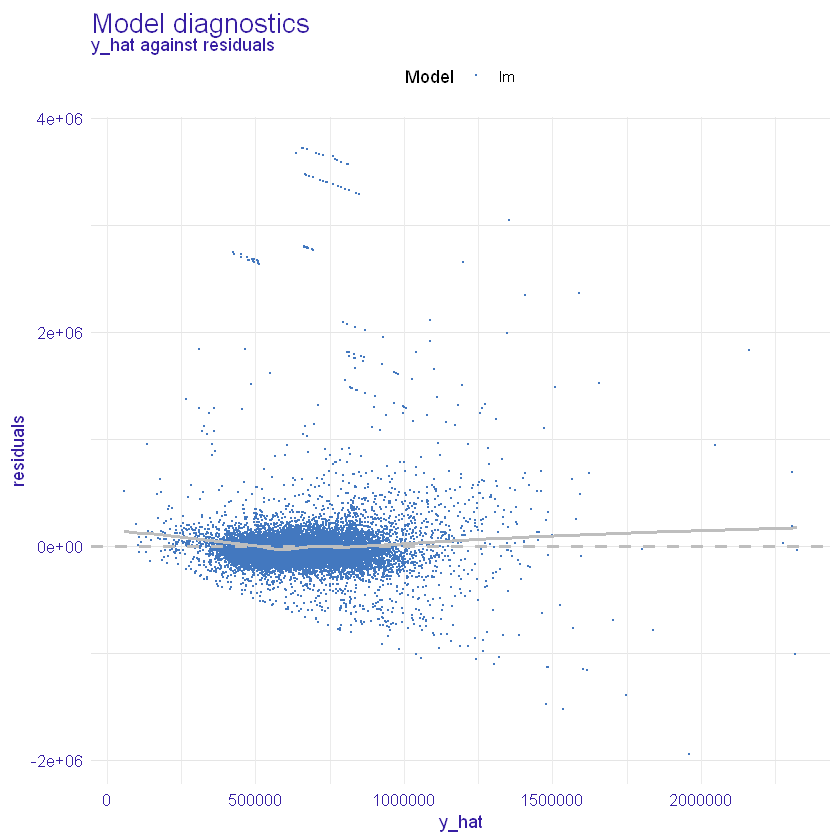

In [94]:
library(DALEX)

explain_lm <- explain(multi_model, data = housing, y = housing$sale_price)

diag_lm  <-model_diagnostics(explain_lm)

plot(diag_lm)


**k. Investigate further by calculating the leverage, cooks distance, and covariance rations. Comment on all cases that are problematics.**


In [95]:
# Leverage was calculated above

df$cooks_distance <- cooks.distance(multi_model)

# No idea what a Covariance Ration is. 


**l. Perform the necessary calculations to assess the assumption of independence and state if the condition is met or not.**


In [96]:
library(lmtest)
dwtest(formula = multi_model)

Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric




	Durbin-Watson test

data:  multi_model
DW = 0.52549, p-value < 2.2e-16
alternative hypothesis: true autocorrelation is greater than 0


**m. Perform the necessary calculations to assess the assumption of no multicollinearity and state if the condition is met or not.**

In [97]:
library(regclass)

kable(VIF(multi_model))

Loading required package: bestglm
Loading required package: VGAM
Loading required package: stats4
Loading required package: splines

Attaching package: 'VGAM'

The following object is masked from 'package:lmtest':

    lrtest

The following objects are masked from 'package:boot':

    logit, simplex

The following object is masked from 'package:tidyr':

    fill

The following objects are masked from 'package:psych':

    fisherz, logistic, logit

Loading required package: rpart
Loading required package: randomForest
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine

The following object is masked from 'package:ggplot2':

    margin

The following object is masked from 'package:psych':

    outlier

Important regclass change from 1.3:
All functions that had a . in the name now have an _
all.correlations -> all_correlations, cor.demo -> cor_demo, etc.





|                         |          x|
|:------------------------|----------:|
|sale_date                | 160.455208|
|sale_reason              |   1.346303|
|building_grade           | 136.135324|
|square_feet_total_living |  18.494635|
|bath_3qtr_count          |   1.667960|
|year_built               | 253.970155|
|year_renovated           |   1.022834|
|sq_ft_lot                |   1.233143|
|present_use              |   1.053212|

Based on our VIF scores, there is very little bias in our data since all values are well below 10 and close to 1.

**n. Visually check the assumptions related to the residuals using the plot() and hist() functions. Summarize what each graph is informing you of and if any anomalies are present.**

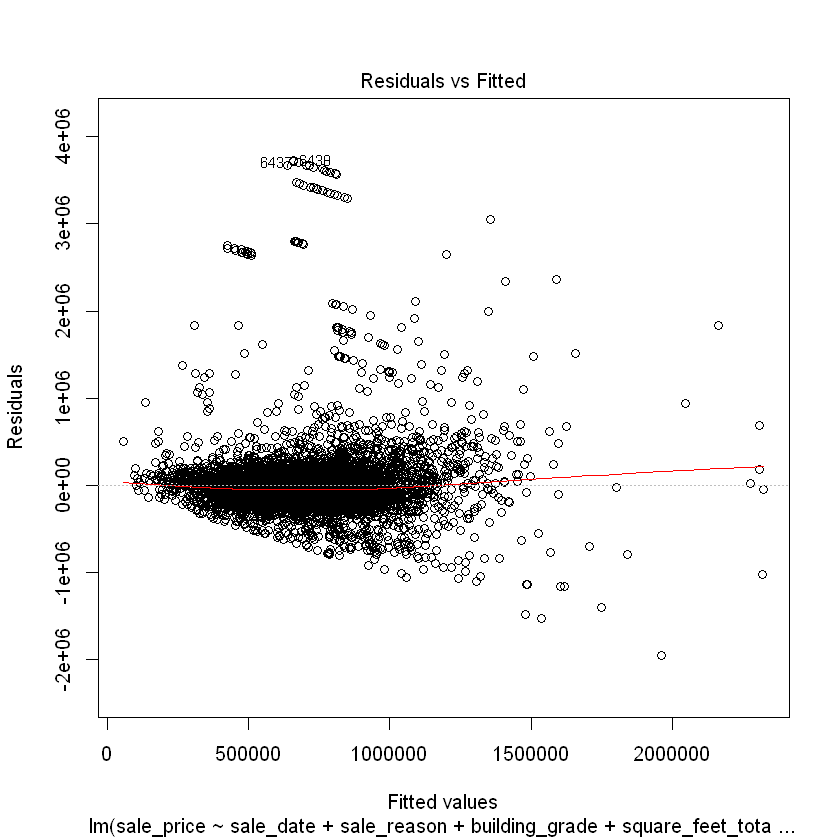

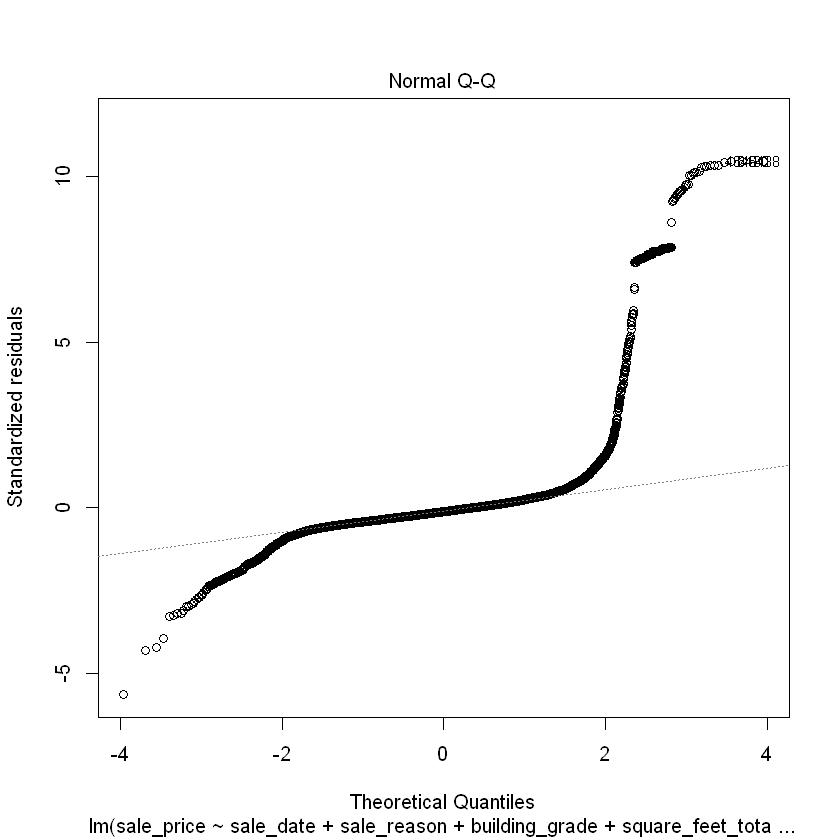

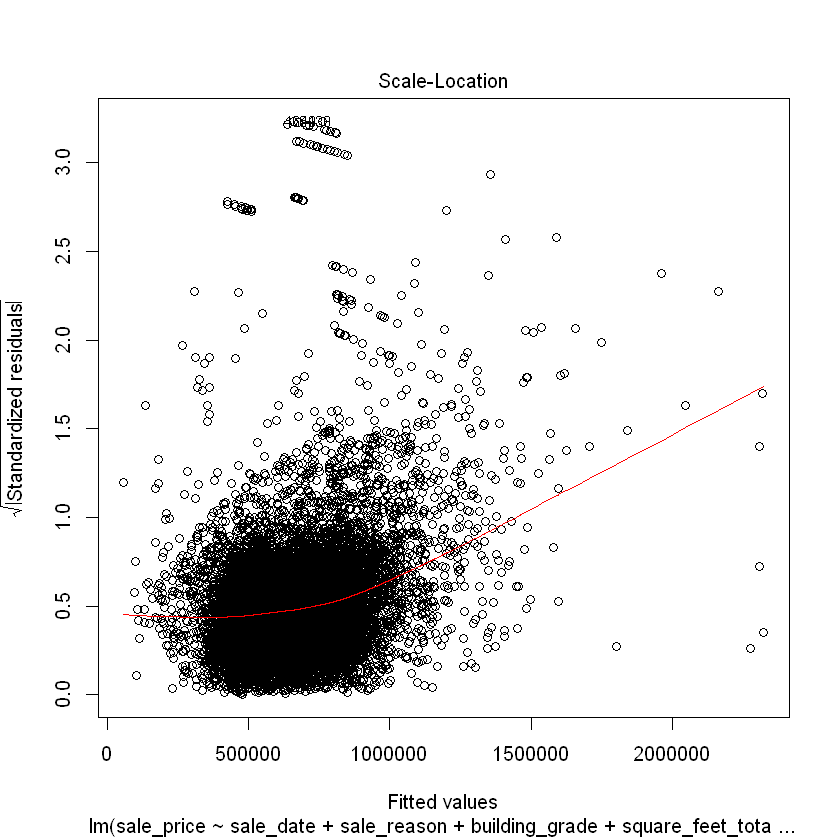

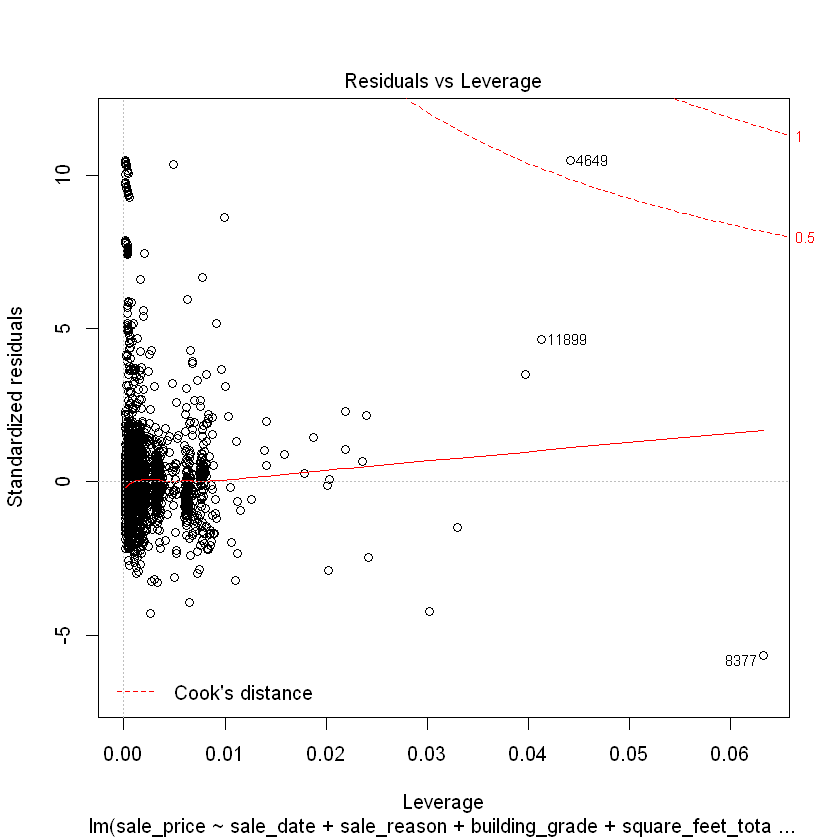

In [98]:
plot(multi_model)

**o. Overall, is this regression model unbiased? If an unbiased regression model, what does this tell us about the sample vs. the entire population model?**

Our model is realtively unbiased after all the checks we have performed. We could further test our theory of robustness by building the sample model with a training set and comparing it against a testing set.

In [99]:
library(caTools)

In [100]:
set.seed(520)

sample <- sample.split(housing$sale_price, SplitRatio = 0.70)

train = subset(housing, sample == TRUE)
test = subset(housing, sample == FALSE)

In [101]:
multi_model <- lm(sale_price ~ 
                    sale_date + 
                    sale_reason + 
                    building_grade + 
                    square_feet_total_living + 
                    bath_3qtr_count + 
                    year_built + 
                    year_renovated + 
                    sq_ft_lot + 
                    present_use - 1, 
                  data = train)
summary(multi_model)


Call:
lm(formula = sale_price ~ sale_date + sale_reason + building_grade + 
    square_feet_total_living + bath_3qtr_count + year_built + 
    year_renovated + sq_ft_lot + present_use - 1, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-2045152  -113566   -38466    41120  3723688 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
sale_date                 1.682e-04  3.370e-05   4.991 6.11e-07 ***
sale_reason              -1.347e+04  1.290e+03 -10.442  < 2e-16 ***
building_grade            4.144e+04  4.941e+03   8.387  < 2e-16 ***
square_feet_total_living  1.569e+02  5.539e+00  28.319  < 2e-16 ***
bath_3qtr_count          -3.054e+04  5.617e+03  -5.437 5.55e-08 ***
year_built               -1.331e+02  2.815e+01  -4.730 2.28e-06 ***
year_renovated            3.536e+01  1.608e+01   2.199  0.02788 *  
sq_ft_lot                 2.027e-01  6.321e-02   3.206  0.00135 ** 
present_use              -5.990e+02  1.130e+02  -5.299 1.19e-07 *

In [102]:
test$predicted <- predict.lm(multi_model, newdata = test)
test$residuals <- test$predicted - test$sale_price

`geom_smooth()` using method = 'gam'


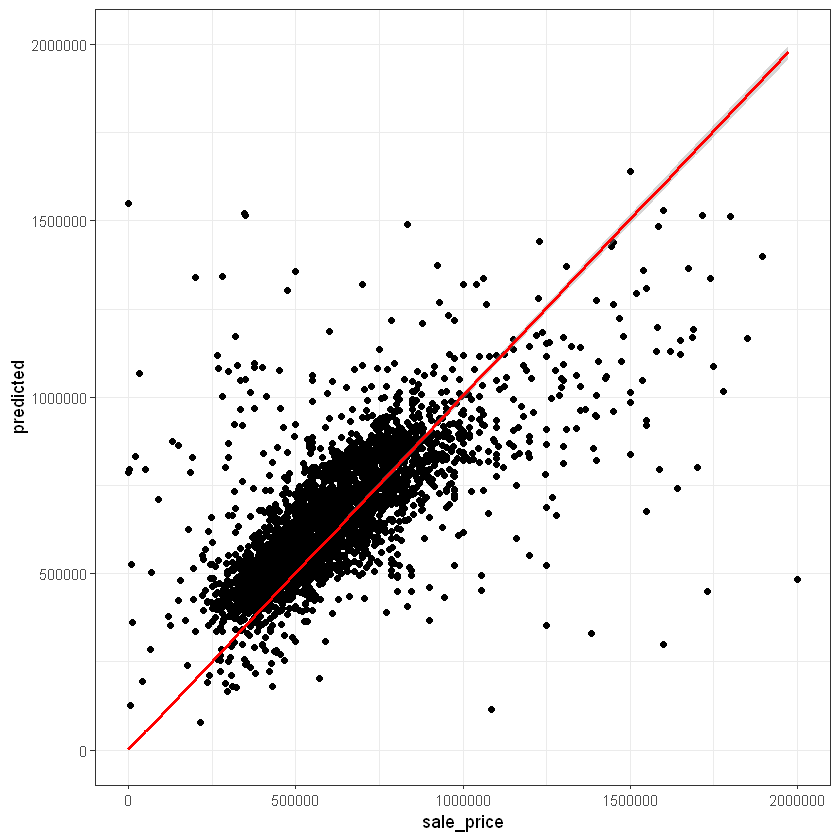

In [111]:
ggplot(data = test, aes(x = sale_price, y = predicted)) + 
geom_point() + 
xlim(0,2000000) + 
ylim(0,2000000) + 
stat_smooth(formula = y ~ x - 1, color = "red") + 
theme_bw()

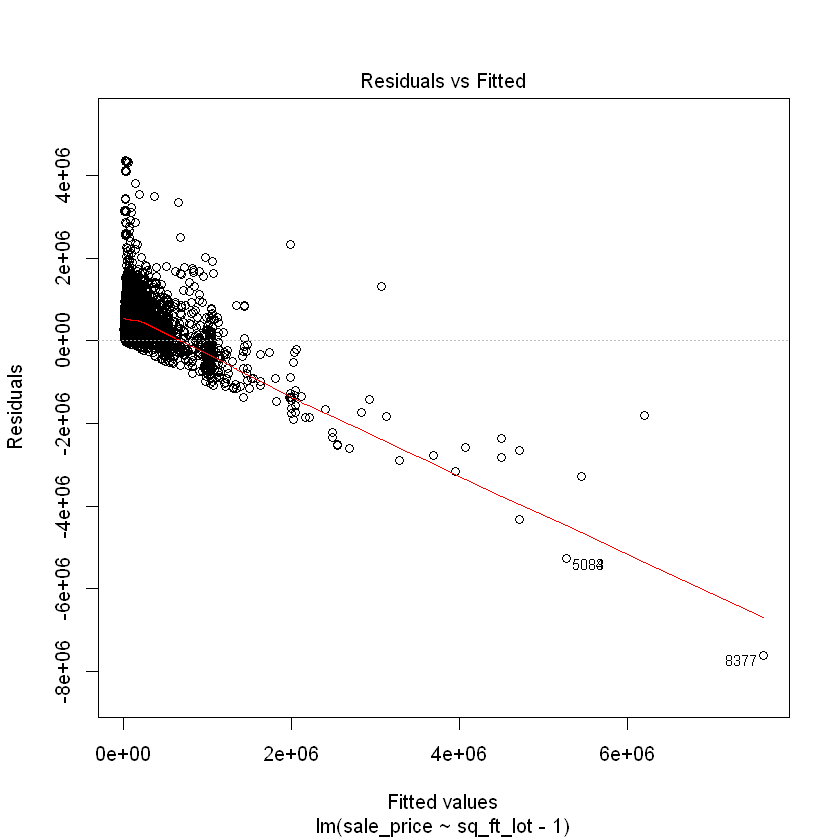

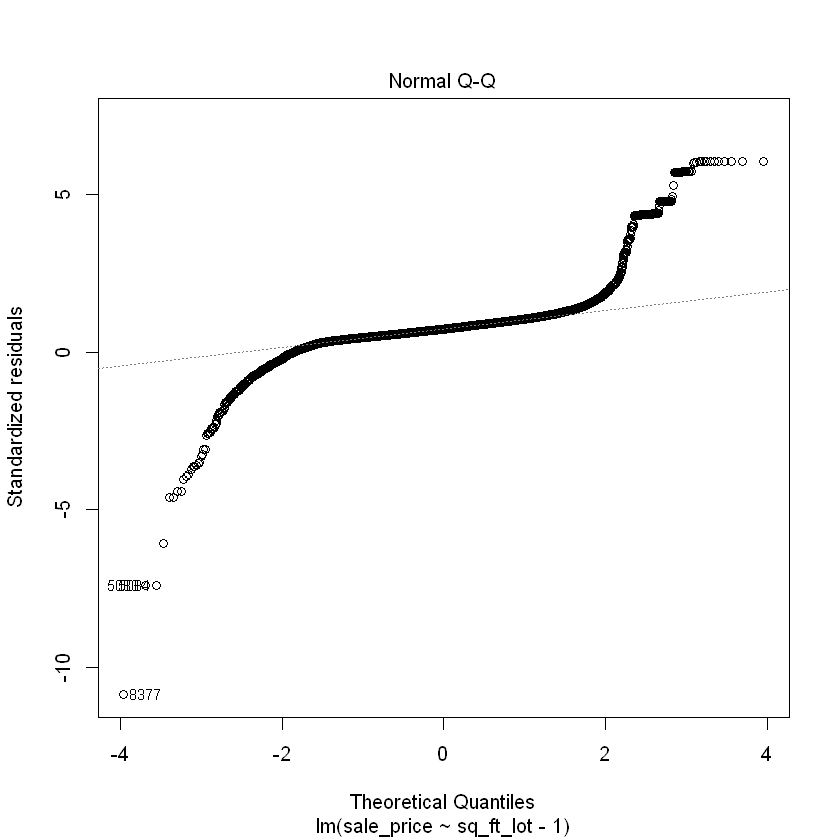

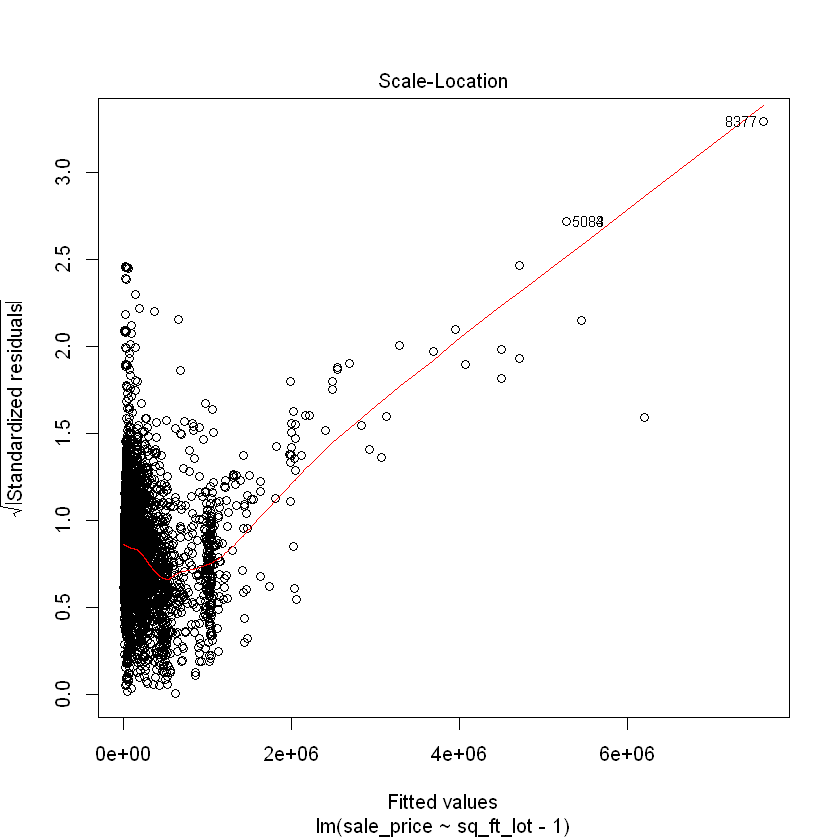

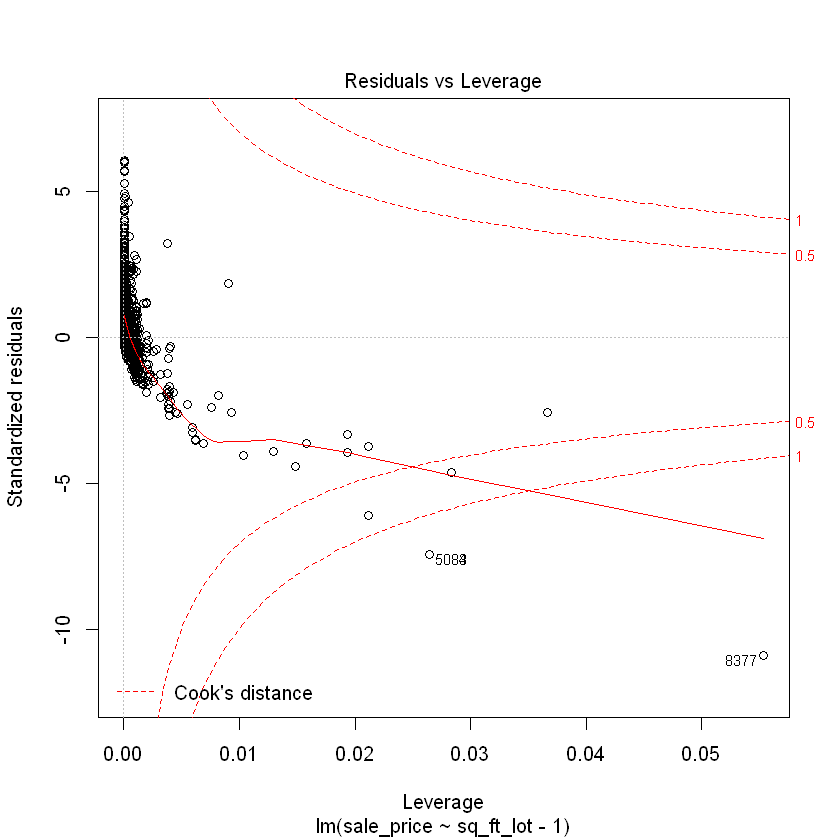

In [104]:
plot(basic_model)

In [156]:
multi_model <- lm(sale_price ~ 
                    sale_date + 
                    sale_reason + 
                    building_grade + 
                    square_feet_total_living + 
                    bath_3qtr_count + 
                    year_built + 
                    year_renovated + 
                    sq_ft_lot + 
                    present_use - 1, 
                  data = housing)

In [157]:
housing$stand_residuals <- rstandard(multi_model)

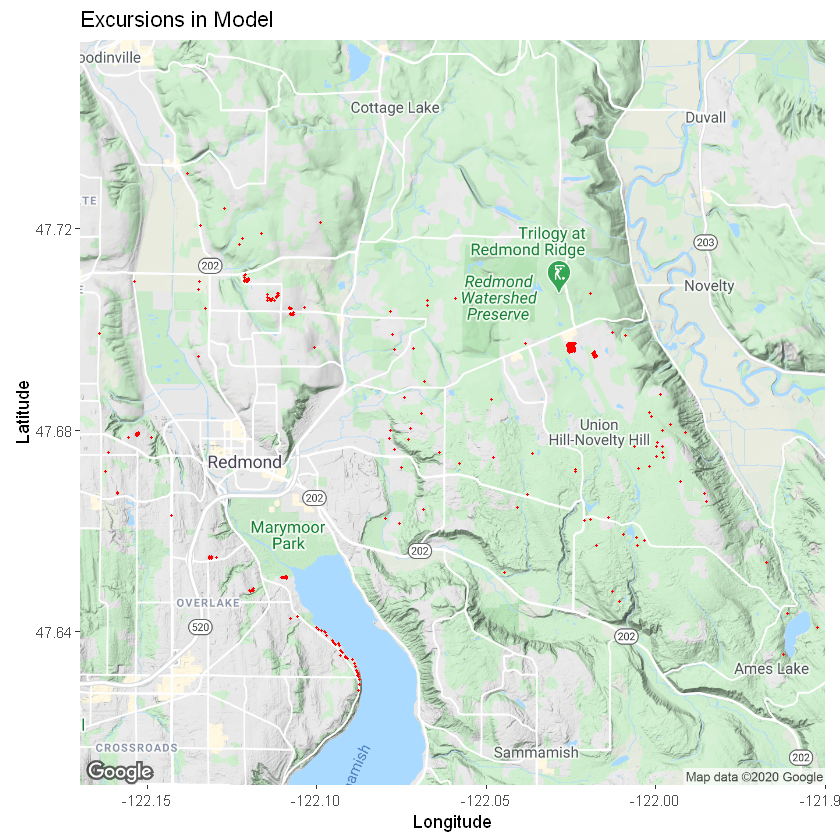

In [158]:
al1MAP + 
geom_point(data = subset(housing, abs(stand_residuals) > 2), 
           mapping = aes(x = lon, y = lat), 
           inherit.aes = FALSE,
           size = 0.5,
           alpha = 1,
           color = "red") +
scale_colour_gradient2() + 
xlab("Longitude") +
ylab("Latitude") +
ggtitle("Excursions in Model") 

In [118]:
al3 = get_map(location = c(lon = -122.024636, lat = 47.696294), 
              zoom = 17, 
              maptype ="hybrid")
al3MAP = ggmap(al3)

Source : https://maps.googleapis.com/maps/api/staticmap?center=47.696294,-122.024636&zoom=17&size=640x640&scale=2&maptype=hybrid&language=en-EN&key=xxx=


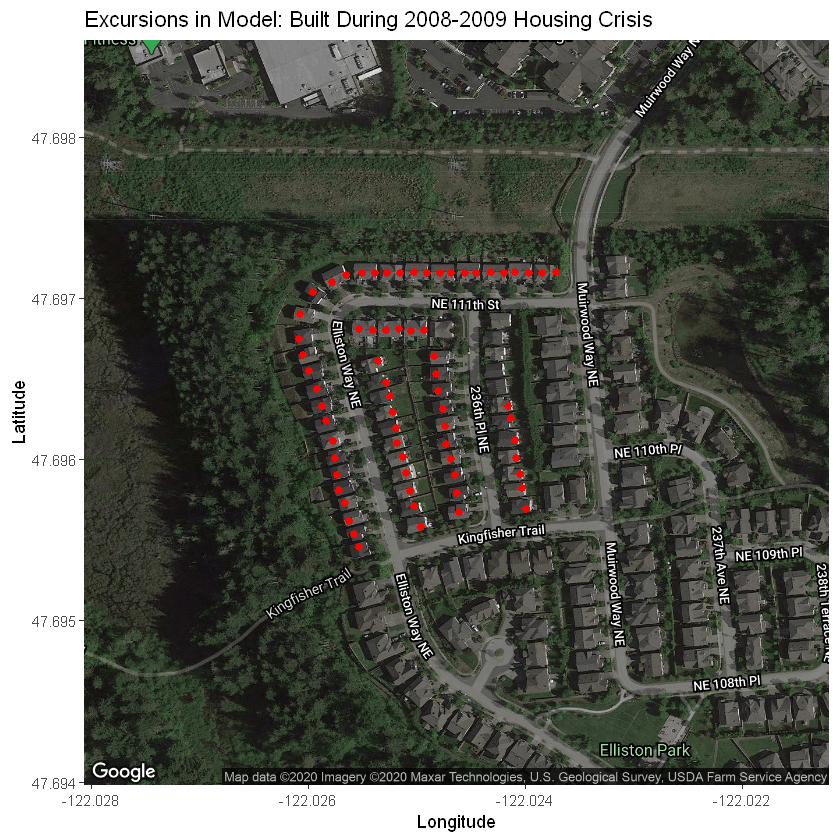

In [163]:
al3MAP + 
geom_point(data = subset(housing, abs(stand_residuals) > 2 & year_built %in% c(2008, 2009)), 
           mapping = aes(x = lon, y = lat), 
           inherit.aes = FALSE,
           size = 2,
           alpha = 1,
           color = "red") +
scale_colour_gradient() + 
xlab("Longitude") +
ylab("Latitude") +
ggtitle("Excursions in Model: Built During 2008-2009 Housing Crisis") 

In [120]:
al4 = get_map(location = c(lon = -122.113136, lat = 47.708216), 
              zoom = 16, 
              maptype ="hybrid")
al4MAP = ggmap(al4)

Source : https://maps.googleapis.com/maps/api/staticmap?center=47.708216,-122.113136&zoom=16&size=640x640&scale=2&maptype=hybrid&language=en-EN&key=xxx=


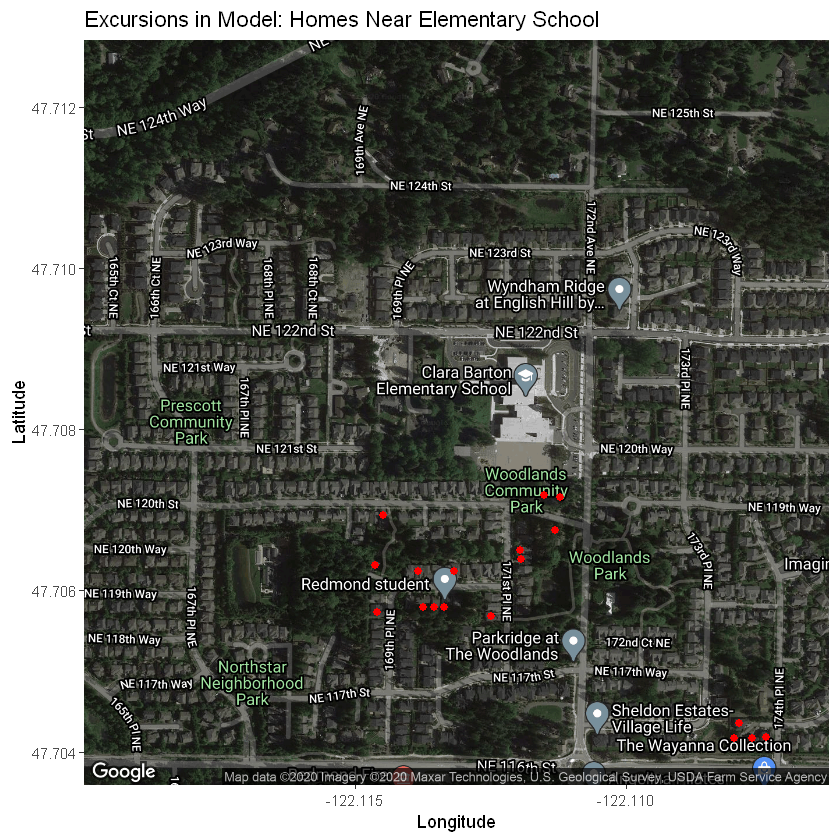

In [160]:
al4MAP + 
geom_point(data = subset(housing, abs(stand_residuals) > 3), 
           mapping = aes(x = lon, y = lat), 
           inherit.aes = FALSE,
           size = 2,
           alpha = 1,
           color = "red") +
scale_colour_gradient2() + 
xlab("Longitude") +
ylab("Latitude") +
ggtitle("Excursions in Model: Homes Near Elementary School") 

In [123]:
al5 = get_map(location = c(lon = -122.087871, lat = 47.631903), 
              zoom = 16, 
              maptype ="hybrid")
al5MAP = ggmap(al5)

Source : https://maps.googleapis.com/maps/api/staticmap?center=47.631903,-122.087871&zoom=16&size=640x640&scale=2&maptype=hybrid&language=en-EN&key=xxx=


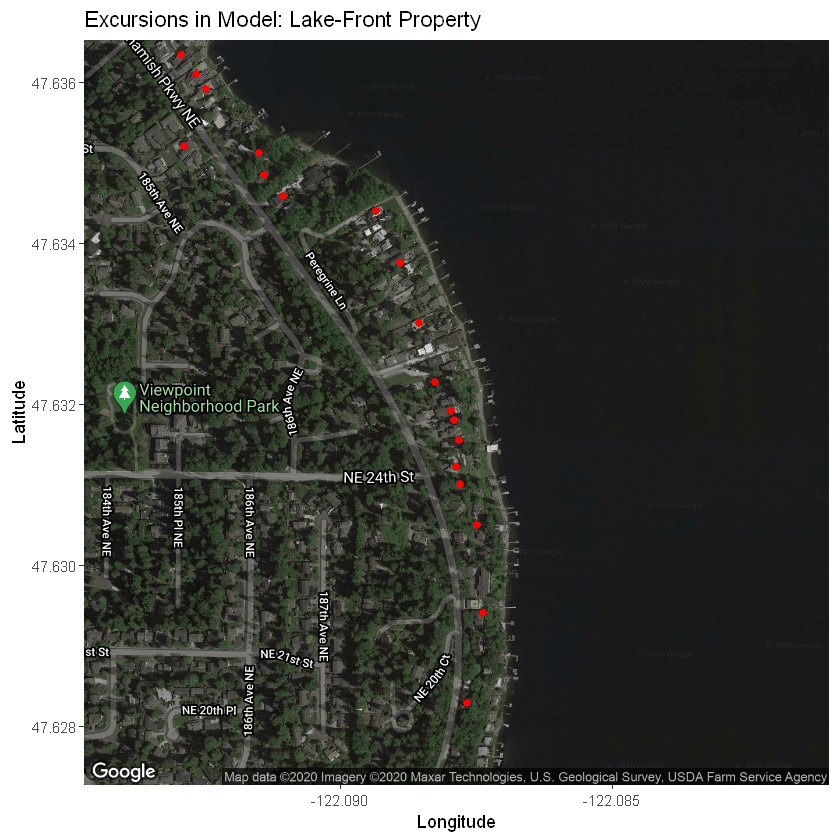

In [161]:
al5MAP + 
geom_point(data = subset(housing, abs(stand_residuals) > 2), 
           mapping = aes(x = lon, y = lat), 
           inherit.aes = FALSE,
           size = 2,
           alpha = 1,
           color = "red") +
scale_colour_gradient2() + 
xlab("Longitude") +
ylab("Latitude") +
ggtitle("Excursions in Model: Lake-Front Property") 